# ASTR 596 Fall 2023 - Surface photometry lab (50 Points)
In this lab we will be performing surface photometry of two nearby galaxies, an elliptical and a spiral.  

This lab will be done via a mixture of python commands using the photutils aperture photometry package (https://photutils.readthedocs.io/en/stable/aperture.html) and the photutils isophote fitting package (https://photutils.readthedocs.io/en/stable/isophote.html).  We will also be using imexam and ds9.

In this lab you will learn how to do the following things:
* estimate the background for an image and subtract it;
* estimate initial guesses for input parameters to an isophotal fitting code using ds9;
* fit elliptical isophotes;
* use photometry within these isophotes to measure the radial profile of various parameters;
* compute the radius within which half the total light is contained.  This is called the effective radius.

<i>Note: Enter in all code to the problems in the provided notebook cells. Questions to answer will be <b>bolded</b>.</i>  

All your answers should be entered in this notebook. Each student will need to hand in their own notebook by uploading it to GitHub following the instructions.

In the code places where you will need to put something or write your own code are specified by `#***************`  You will not get points for doing this unless explicitly noted.  Some of these things are just to make sure you are setting up your paths correctly.

**Due on <font color='red'>11/20 at Noon</font>** to be handed into the "Surface Photometry" assignment in <font color='red'>Module 7</font>.

You will need to download the raw data from https://www.dropbox.com/t/9JMlIMfRblkfGiAY.  There are four galaxy images.  You will need to measure something from all of them.  The galaxies are:
* NGC 3982
* NGC 5198
* NGC 5985
* PCG 0997820

I suggest you make a directory on your computer called `~/ASTR596/Data` and put data in there in a directory you name that is specific to this assignment.  

In [1]:
#import 
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.io import fits
import glob
import os
from scipy.stats import scoreatpercentile
import astropy.units as u
from scipy import stats

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import colors


from astropy.nddata import CCDData
#from ccdproc import ImageFileCollection, Combiner, combine
#from ccdproc import wcs_project

### Some functions to display the images and overplot the stars

In [2]:
def imdisplay(image, v1perc=10, v2perc=95, logscale=True):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    print(v1,v2)
    if (logscale):
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',norm=colors.LogNorm(vmin=v1,vmax=v2),origin='lower')
    else:
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',vmin=v1,vmax=v2,origin='lower')
        
    cbar = fig.colorbar(im, ax=ax, fraction=0.04)
    cbar.ax.set_ylabel('counts')
    return fig,ax
    #fig.colorbar(fraction=.08)

In [3]:
#***************
#put your data directory here
homedir = os.getenv('HOME')
datadir = homedir+ '/Downloads'
os.chdir(datadir)

## Display the image in DS9

SAOimage DS9 is a popular and easy to use image viewer.  There are various tutorials at https://sites.google.com/cfa.harvard.edu/saoimageds9/documentation?authuser=0 .

Here is another third party tutorial https://astrobites.org/2011/03/09/how-to-use-sao-ds9-to-examine-astronomical-images/ 

In the following description I will refer to menu choices as those at the top of the screen or window.  I will refer to buttons as the double line of buttons right above where the image is displayed.  I will refer to sub buttons with **button1**->**button2**

1. In DS9 open `NGC3982-custom-image-r.fits`
2. Under the **scale** button choose **log** and **zscale**.  In the Menu bar choose Scale->Scale parameters.  In the "high" box choose 3.
3. Use the right mouse button to change the stretch on the image.  You may need to select the **edit**->**none** or **edit**->**colorbar** button for this to work.


## Problem 1 - Estimate the background and subtract it (5 Points)

Before performing photometry you need to subtract off the background.  To do this for this exercise you are going to:
1. pick a square region in each of the 4 corners of the image and compute the best estimate of the background level over all the pixels in these areas.  Note that the straight average may not be the best option.
2. subtract this background level from the image 
3. display the background subtracted image

#### 1. compute background level
Here is an example of how to display an image with a log scaling.

10.19071102142334 11.842433891296398


Text(0.5, 1.0, 'NGC3982-custom-image-r.bkg.fits')

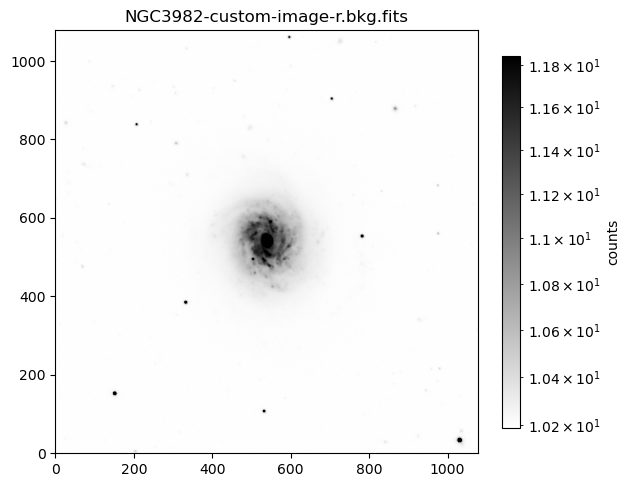

In [4]:
imname = 'NGC3982-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))
data,header = fits.getdata(imname, header=True)
imdisplay(data,v1perc=1,v2perc=99.9,logscale=True)

plt.title(imname)

This is a code that will take in an image name and data, as well as corners of background boxes, and will measure the background in two different ways.

In [5]:
def background_meas(imname,data,header,fig,ax,corners,bkg_size=5):
    #need to find ways to select regions of pixels in image
    imdisplay(data,v1perc=1,v2perc=99,logscale=True)

    plt.title(imname)

    #print out the x and y-dimension of the image using the header keywords
    print('image xdim = ', header['NAXIS1'], '; image ydim = ',header['NAXIS2'])
    #the length of each background box size
    #bkg_size = 200

    #make an array whose elements are the different data sections.
    reg = np.array([])


    #specify the different regions.  Each will be appended to the reg array.  the reg array is therefore 3 dimensional.  
    #the first dimension is for each region.  Each of those dimensions contains a 2D array that holds the image section.
    reg = np.append(reg, data[corners[0][0]:bkg_size-1, corners[0][1]:bkg_size-1])    #lower left corner
    reg = np.append(reg, data[corners[1][0]:bkg_size-1, corners[1][1]:])    #upper left corner
    reg = np.append(reg, data[corners[2][0]:, corners[2][1]:])    #upper right corner
    reg = np.append(reg, data[corners[3][0]:, corners[3][1]:bkg_size-1])   #lower right corner

    #print the median and mode of all the pixels. 
    #bkgmode =stats.mode(reg.flatten(),keepdims=False)[0]
    #Prof. Rudnick changed this because for some reason the keepdims 
    #parameter threw an error
    bkgmode =stats.mode(reg.flatten())[0]
    bkgmed = np.median(reg)
    print('mode = ',bkgmode)
    print('median = ',bkgmed)

    #Overlay rectangles with the background region indicated
    rectlist = []
    #loop through all images 
    for corn in corners:
        rect = plt.Rectangle((corn),bkg_size, bkg_size,linewidth=2,angle=0.0)
        rectlist.append(rect)
        pc = PatchCollection(rectlist,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_collection(pc)
        
    return bkgmode,bkgmed


Open the image in ds9 and use the log stretch to see if you can define corners of the image that are relatively free of galaxy light at a hard stretch.  You will compute the average pixel value in each of these regions and take the average.  It is ok if there are stars in these regions.  You should have 4 regions for the image.  An example that works for this image is shown below.  

**Note**
* to make it simpler, the boxes should be equal in size.  You will need to specify the lower left corner of each box.
* The images I am providing here have been selected from much larger images from the DESI Legacy Survey https://www.legacysurvey.org/viewer .  Therefore they do not have strange behavior around the edges and you can use the edges of the image as the edges of your sky region without any buffer region.

To make your coding easier, I'm going to make a bunch of dictionaries such that the main variable name is the same and you only have to change the galaxy name with the galname variable.

In [6]:
#initialize dictionaries that contains names of images and headers
imname = {}
data = {}
header = {}
corners = {}
bkgdim = {}

#statistics of background
bkgmode = {}
bkgmed = {}

In [7]:
#a routine to plot the images with the background measurement corners shown in red
def bkgregplot(data,header,imname, bkgdim, fig, ax):
    #define lower-left corners of each region
    corners = []
    corners.append([0,0])
    corners.append([0,header['NAXIS2']-bkgdim])
    corners.append([header['NAXIS1']-bkgdim, header['NAXIS2']-bkgdim])
    corners.append([header['NAXIS1']-bkgdim,0])

    #run the background_meas code to measure the background and plot the background regions
    bkgmode,bkgmed = background_meas(imname, data, header, fig, ax, 
                                                       corners,bkg_size=bkgdim)
    return bkgmode, bkgmed

### NGC3982

10.19071102142334 10.892627716064453
image xdim =  1079 ; image ydim =  1079
mode =  10.198768615722656
median =  10.20020866394043


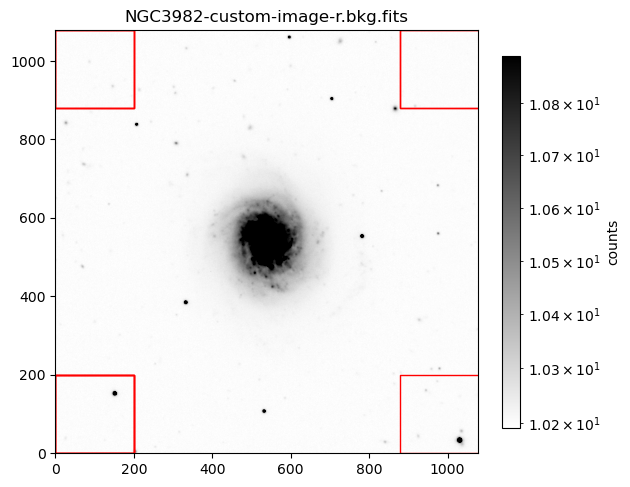

In [8]:
galname = 'NGC3982'
imname[galname] = 'NGC3982-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)


bkgdim[galname]= 200

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)


### NGC5198

5.3430326461792 5.763217258453368
image xdim =  1131 ; image ydim =  1131
mode =  5.3495049476623535
median =  5.349852085113525


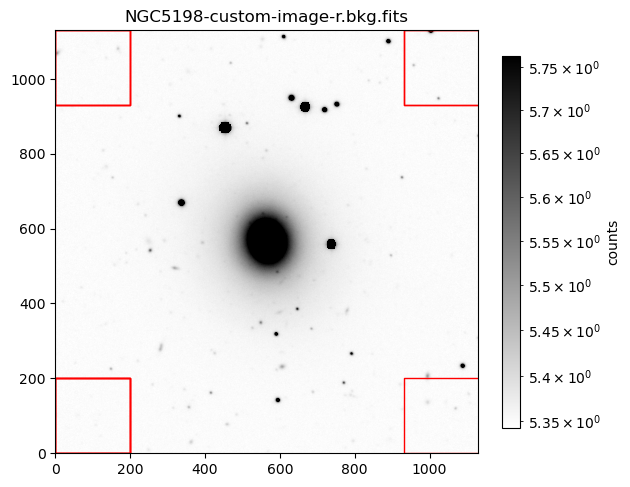

In [9]:
#*******************
#write your code here
galname = 'NGC5198'
imname[galname] = 'NGC5198-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)


bkgdim[galname]= 200

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)

### NGC5985

22.116252899169922 22.362007522583006
image xdim =  2291 ; image ydim =  2291
mode =  22.12144660949707
median =  22.122682571411133


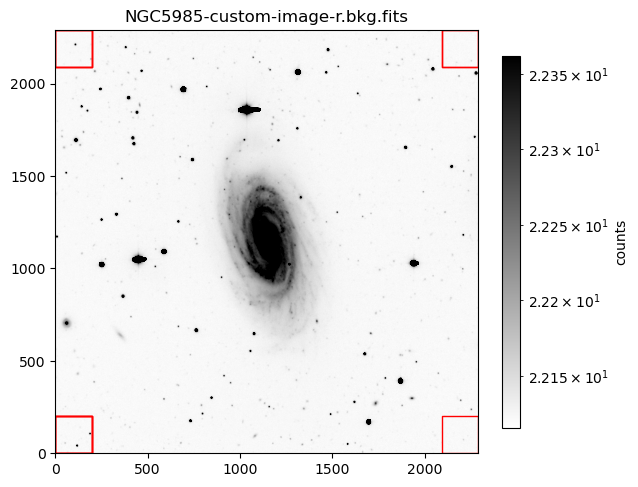

In [10]:
#*******************
#write your code here
galname = 'NGC5985'
imname[galname] = 'NGC5985-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)


bkgdim[galname]= 200

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)

### PCG0997820

5.341621627807617 5.481662235260011
image xdim =  403 ; image ydim =  403
mode =  5.351508617401123
median =  5.350395679473877


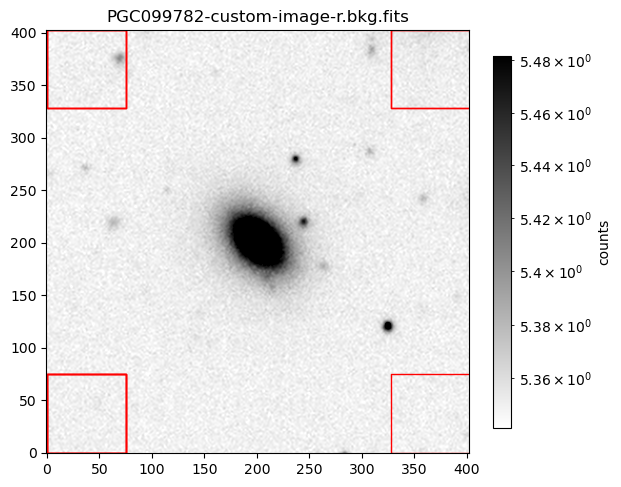

In [11]:
#*******************
#write your code here
galname = 'PGC0997820'
imname[galname] = 'PGC099782-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)


bkgdim[galname]= 75

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)

#### 2. subtract background and display subtracted image

In this component you will need to:
* subtract your background from the previously read in image
* display that image
* write out your image

I provide one example below and you will need to do the other 3.  Note that since counts can be negative, you will need to choose v1perc to make sure that the lowest counts are positive.  The limits of the colorbar scale are printed after the imdisplay() command so you will see how far you are away.

In [12]:
#initializse dictionary that will hold background subtracted images
data_bsub = {}
imname_bsub = {}

### NGC 3982

0.0014181137084960938 1.6422252273559677


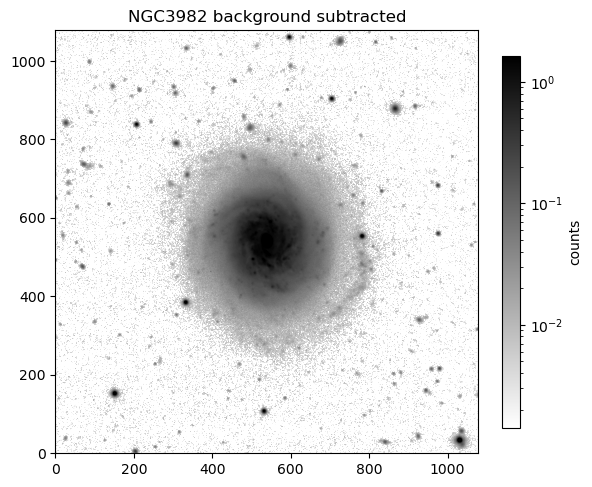

In [13]:
galname = 'NGC3982'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=50.,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### NGC 5198

0.0028476715087890625 10.000118255615234


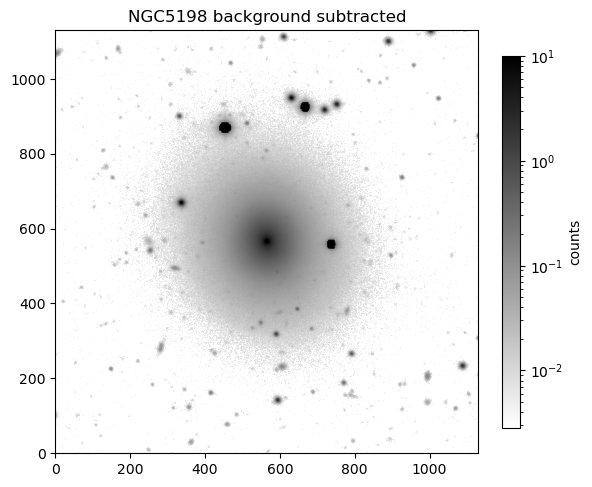

In [14]:
#***************
#your code goes here
galname = 'NGC5198'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=55,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### NGC 5985

0.0024890899658203125 10.000299453735352


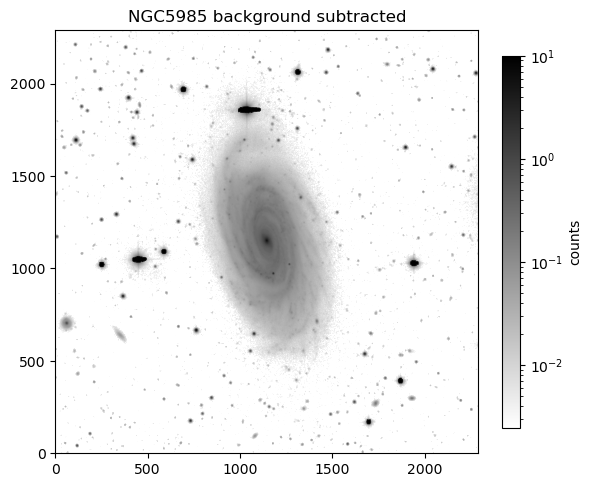

In [15]:
#***************
#your code goes here
galname = 'NGC5985'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=60.,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### PGC 0997820

0.002911376953124996 0.6742485427856486


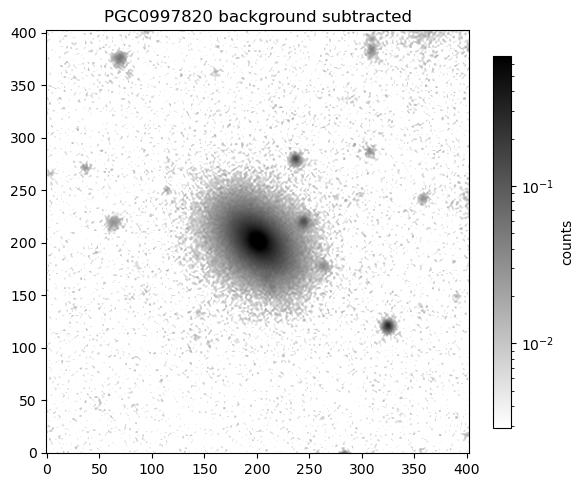

In [16]:
#***************
#your code goes here
galname = 'PGC0997820'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=70.,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

**Question**: comment on the differences between the images with background and those with background subtracted.  Please describe why you think this is.

put answer here: The images with the background have more counts than those with the subtacted which implies there is more 'noise' in the picture. The subtracted background images seem to focus more on the inner details of our galaxies while the ones with background are more uniform and all look like blobs due to the background being present.

## Problem 2 - estimate initial guesses for ellipse parameters (15 Points)
The `photutils` package that we will be using for doing our photometry requires initial guesses for the center, semi-major axis, ellipticity, and position angle.  We will measure these using DS9.  
* xcen, ycen: What you think the center is by using the cursor on ds9

* semi-major axis, ellipticity, PA: For the other items you will need to make an elliptical region in ds9 that matches where the brighter part of the galaxy is.  If you double click on the region it will bring up a dialog box that lets you adjust the PA and also will output the semi-major and semi-minor axes, which you will need for the ellipticity measurement.  You should display the information in pixels using the dropdown to the right of the `radius` field in the "Ellipse" window.  Choose `Image`

**Note**: In ds9, when the first radius in the `Ellipse` window is the semi-major axis, the PA is measured South of East.  This is the same sense as the Elliptical Isophote package in the following problem uses.

For each galaxy, provide these intial guesses.  I will be storing these as a python dictionary for each galaxy.

These guesses do not need to be super precise but they need to be in the right ballpark.

In [17]:
#initialize the dictionary containing the intial parameters for the ellipse fitting
initparams = {}

#### NGC 3982

In [18]:
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC3982'
initparams[galname] = {}
initparams[galname]['xcen'] = 541
initparams[galname]['ycen'] = 541
initparams[galname]['sma'] = 96
initparams[galname]['ellip'] = 96./116.
initparams[galname]['PA'] = 90.0

#### NGC 5198

In [19]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC5198'
initparams[galname] = {}
initparams[galname]['xcen'] = 566
initparams[galname]['ycen'] = 566
initparams[galname]['sma'] = 74
initparams[galname]['ellip'] = 72./74.
initparams[galname]['PA'] = 90.0

#### NGC 5985

In [20]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC5985'
initparams[galname] = {}
initparams[galname]['xcen'] = 1149
initparams[galname]['ycen'] = 1149
initparams[galname]['sma'] = 261
initparams[galname]['ellip'] = 158./261.
initparams[galname]['PA'] = 100.0

PGC 0997820

In [21]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'PGC0997820'
initparams[galname] = {}
initparams[galname]['xcen'] = 202
initparams[galname]['ycen'] = 202
initparams[galname]['sma'] = 27.
initparams[galname]['ellip'] = 27./35.
initparams[galname]['PA'] = 140.0

## Problem 3 - fit elliptical isophotes and measure the radial profiles for various ellipse paramters (15 Points)

We will now use the `photutils.isophot()` task to fit elliptical isophotes (https://photutils.readthedocs.io/en/stable/isophote.html).  An "isophote" is a line of constant surface brightness, akin to a countour on a topographical map.  To get a visual representation of an isophote do the following:
* open one of the background subtracted images in ds9 and dislay it in log scale
* in the analysis menu open "contour parameters" and set the number of countours to 10.  Then hit `Generate` and then `Apply`

The green lines on your image connect pixels of identical flux.  Since the pixels have the same area within a given image, these lines therefore connect points of constant surface brightness.

The `photutils.isophote()` code that we will be using fits ellipses to the isophotes.

In [22]:
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

#define an empty dictionary that will contain the EllipseGeometry instance
geometry = {}

 We must provide the elliptical isophote fitter with an initial ellipse to be fitted. This ellipse geometry is defined with the **EllipseGeometry** class. Here we’ll define an initial ellipse from our answer to problem 2.

### NGC 3982

0.0014181137084960938 1.6422252273559677


(<matplotlib.patches.Ellipse at 0x7fa4bb6a6230>,)

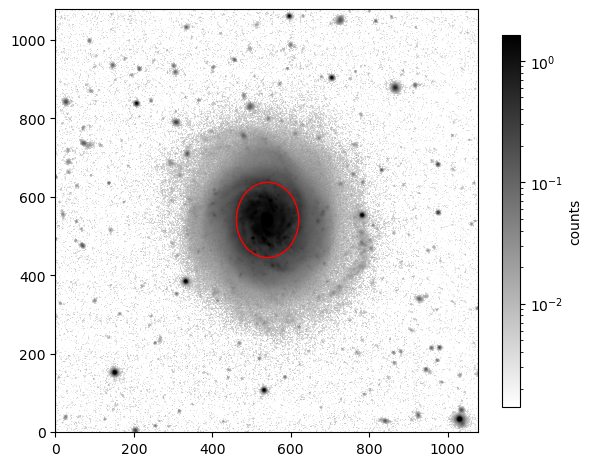

In [23]:
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC3982'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=50,v2perc=99.9,logscale=True)
aper.plot(color='red')

### NGC 5198

0.0028476715087890625 10.000118255615234


(<matplotlib.patches.Ellipse at 0x7fa504d826e0>,)

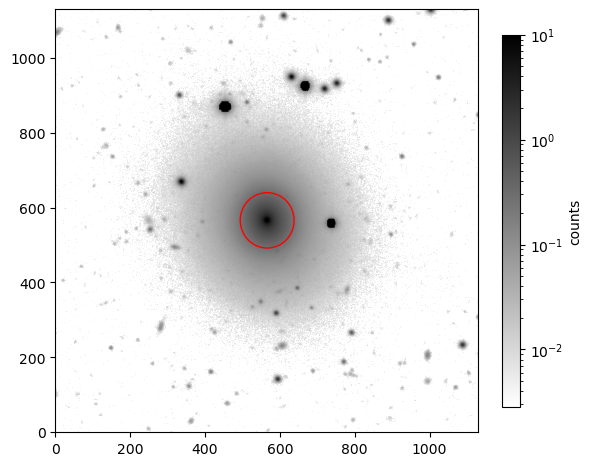

In [24]:
#***************************
#Your code here
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC5198'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=55,v2perc=99.9,logscale=True)
aper.plot(color='red')

### NGC 5985

0.0024890899658203125 10.000299453735352


(<matplotlib.patches.Ellipse at 0x7fa504cb5600>,)

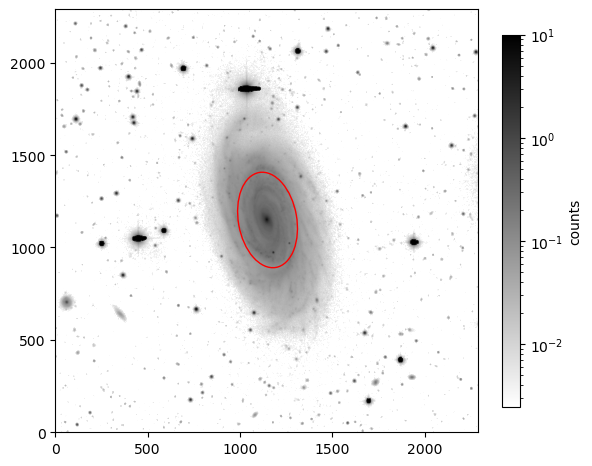

In [25]:
#***************************
#Your code here
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC5985'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=60,v2perc=99.9,logscale=True)
aper.plot(color='red')

### PGC 0997820

0.002911376953124996 0.6742485427856486


(<matplotlib.patches.Ellipse at 0x7fa4b8b26200>,)

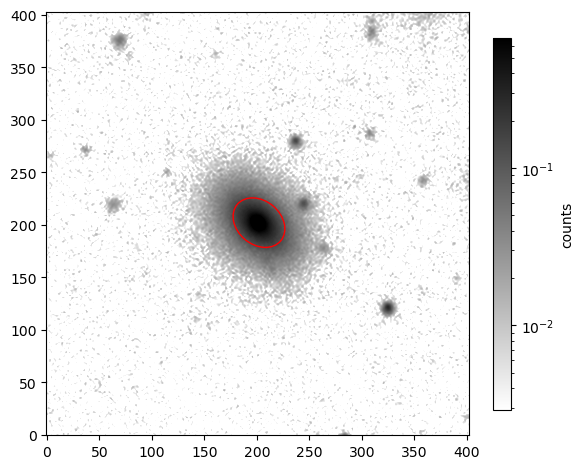

In [26]:
#***************************
#Your code here
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'PGC0997820'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=70,v2perc=99.9,logscale=True)
aper.plot(color='red')

make a subroutine to plot our outputs of ellipse fitting

In [27]:
def plotellipse(isolist):
    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(hspace=0.35, wspace=0.35)

    #plot the semi-major axis vs. the ellipticity
    plt.subplot(2, 2, 1)
    plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
                 fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('Ellipticity')

    #plot the semi-major axis vs. the PA
    plt.subplot(2, 2, 2)
    plt.errorbar(isolist.sma, isolist.pa / np.pi * 180.0,
                 yerr=isolist.pa_err / np.pi * 80.0, fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('PA (deg)')

    #plot the semi-major axis vs. the x center of that ellipse
    plt.subplot(2, 2, 3)
    plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('x0')

    #plot the semi-major axis vs. the y center of that ellipse
    plt.subplot(2, 2, 4)
    plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('y0')

Next, we create an instance of the Ellipse class, inputting the data to be fitted and the initial ellipse geometry object:

In [28]:
from photutils.isophote import Ellipse

#initialize dictionary for ellipse fitting
ellipse = {}
isolist = {}

The values computed by the fitting process are the attributes at this table https://photutils.readthedocs.io/en/stable/api/photutils.isophote.Isophote.html#photutils.isophote.Isophote

I will do the first galaxy for you and you will need to do the other three

### NGC 3982

In [29]:
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC3982'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

       sma                intens        ... niter stop_code
                                        ...                
------------------ -------------------- ... ----- ---------
               0.0   13.573950953741187 ...     0         0
  0.50777761257742    13.41902604496207 ...    10         0
0.5585553738351621   13.396664110082979 ...    10         0
0.6144109112186783    13.37302688388951 ...    10         0
0.6758520023405461   13.317632646902677 ...    10         0
0.7434372025746008     13.1983546670543 ...    10         0
               ...                  ... ...   ...       ...
154.60896000000005  0.06403689979000197 ...    10         0
170.06985600000007  0.04052559163393898 ...    50         2
 187.0768416000001  0.02420955496801546 ...    50         2
205.78452576000012 0.016440212223330454 ...    50         2
226.36297833600014  0.01108956349496505 ...    50         2
248.99927616960017 0.007553276667398323 ...    14         5
 273.8992037865602 0.006733950435401152 

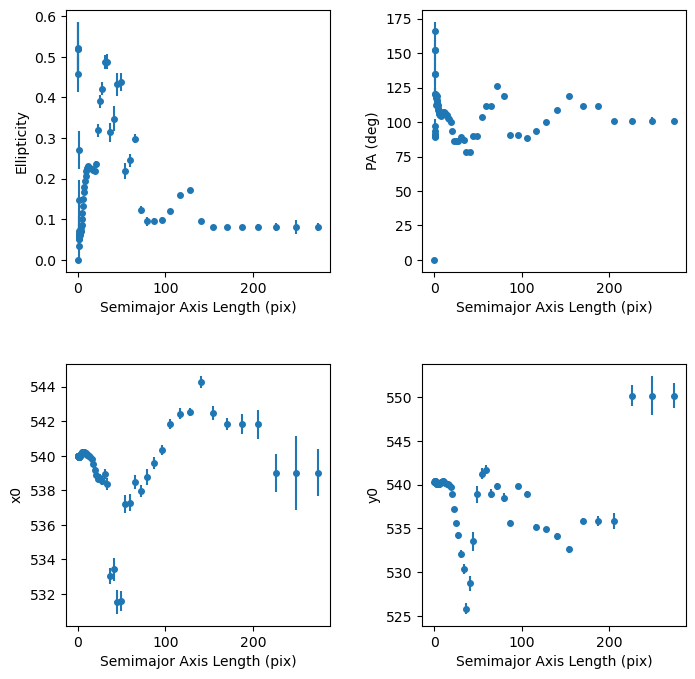

In [30]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].to_table())

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

**put answer in this cell**: The ellipticity plot shows that the ellipticity of the plot changes as a function of the semi-major axis. In this case, we can see that ellipticity goes up before going straight back down. This suggests that a very elliptic structure must be in the galaxy, likely the bulge. The same goes for the PA. There is a hill were the bulge must be before settling into something relatively constant which means that its structure is relatively consistent. Finally, we can see in the y0 and x0 plots that there is some inconsistency between the y0 and x0 and the semimajor axis. This probably represents that the plot is elongated or at least not consistent.

### NGC 5198

In [31]:
#***************************
#Your code here
galname = 'NGC5198'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

       sma                intens        ... niter stop_code
                                        ...                
------------------ -------------------- ... ----- ---------
               0.0    17.02119956439221 ...     0         0
0.5209692518041703    16.82508093209575 ...    10         0
0.5730661769845874   16.811098949618586 ...    11         0
0.6303727946830462    16.78360186830692 ...    11         0
0.6934100741513508    16.72355357919805 ...    10         0
 0.762751081566486   16.646786981233042 ...    10         0
               ...                  ... ...   ...       ...
131.09551400000007  0.07675806829578079 ...    10         0
144.20506540000008  0.06165308806707248 ...    10         0
 158.6255719400001   0.0496021308434258 ...    50         2
174.48812913400013 0.040356056508996645 ...     5         5
191.93694204740015  0.03325928454514241 ...    50         2
 211.1306362521402 0.024514792697642673 ...    50         2
232.24369987735423 0.019759520208197056 

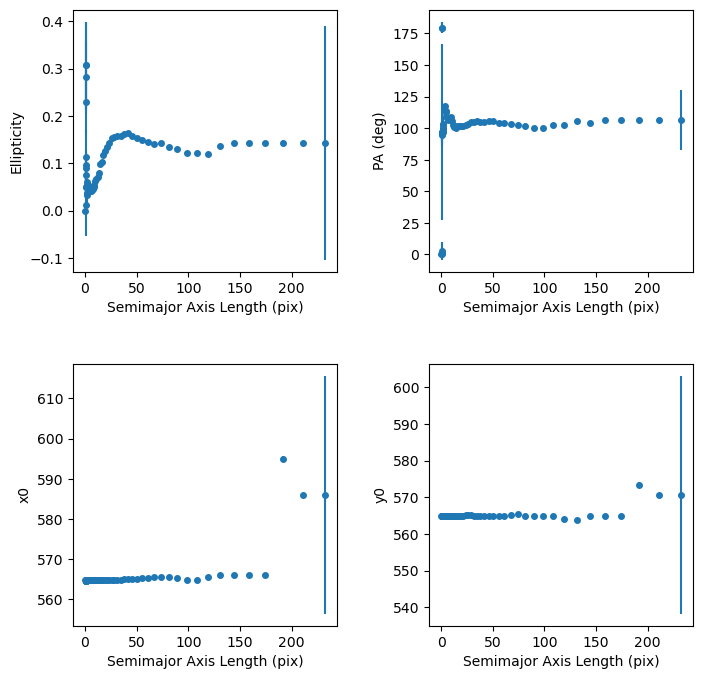

In [32]:
print(isolist[galname].to_table())

plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

**put answer in this cell**: We can take a look at this galaxies graphs and immediately tell that it is fairly uniform and an elloptical galaxy. Each graph shows barely any major changes. We can still see where a bulge is on the graph with the PA and ellipticity but otherwise the galaxy doesn't appear to have any major changes in how it looks. We can see this in the image we have of the galaxy, as well.

### NGC 5985

In [33]:
#***************************
#Your code here
galname = 'NGC5985'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

       sma                intens        ... niter stop_code
                                        ...                
------------------ -------------------- ... ----- ---------
               0.0    6.425828827063426 ...     0         0
0.5322503700470064    6.332469049287807 ...    10         0
0.5854754070517071    6.319189443678535 ...    10         0
0.6440229477568779    6.304648465168019 ...    10         0
0.7084252425325657    6.288760967080943 ...    10         0
0.7792677667858222    6.270995288139297 ...    10         0
               ...                  ... ...   ...       ...
 559.4766794100004 0.014909171366708369 ...     8         5
 615.4243473510005 0.013824151470093478 ...    14         0
 676.9667820861006 0.004433477201907958 ...     8         5
 744.6634602947107  0.04708485704738643 ...    11         0
 819.1298063241818 0.004726223817001872 ...    11         0
    901.0427869566 0.002231991396638525 ...     8         5
 991.1470656522602  0.05337255591972687 

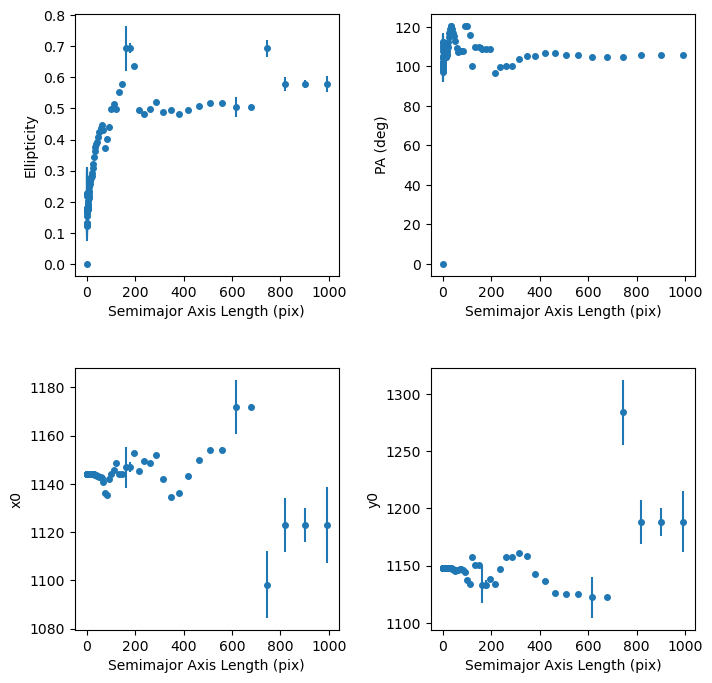

In [34]:
print(isolist[galname].to_table())

plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

**put answer in this cell**: This one is similar to the first but also really different. We can see in the ellipticity  that it starts low and goes way up. This suggests that there are quite a few different structures to consider in this galaxy and that it probably is not elliptical. The PA shows uniformity and that the galaxy has consistentcy. The x0 and y0 shows that there is clear elongation in the galaxy and varies widely. We can see from our image that it looks like a spiral galaxy which is consistent with what we see here.

### PGC 0997820

In [35]:
#***************************
#Your code here
galname= 'PGC0997820'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

       sma                 intens        ... niter stop_code
                                         ...                
------------------ --------------------- ... ----- ---------
               0.0     1.356158533135814 ...     0         0
0.5423300546444173    1.3459547760997401 ...    10         0
0.5965630601088591    1.3432242125795506 ...    14         0
 0.656219366119745    1.3419036467125167 ...    10         0
0.7218413027317194    1.3402832059229115 ...    10         0
0.7940254330048914    1.3380522235839316 ...    10         0
               ...                   ... ...   ...       ...
 52.61536170000004  0.024686165810828362 ...    10         0
 57.87689787000004   0.01497961586185572 ...    50         2
63.664587657000055  0.010513756914796116 ...    50         2
 70.03104642270007  0.009185863193439671 ...    12         0
 77.03415106497009  0.006007338248677193 ...    50         2
 84.73756617146711 0.0038990796130260828 ...    49         5
 93.21132278861383 0.002

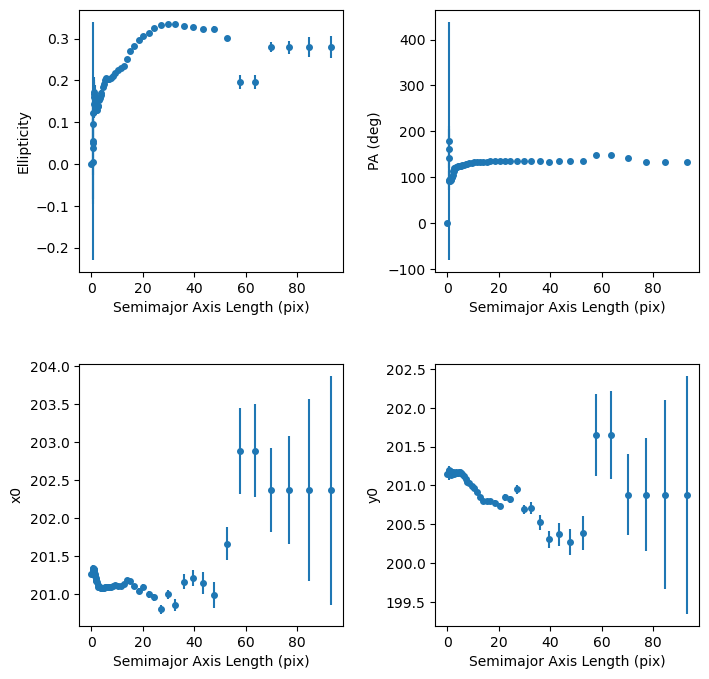

In [36]:
print(isolist[galname].to_table())
plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

**put answer in this cell**: In this galaxy, we see that ellipticity goes up then plateaus. This suggests that our galaxy likely has a pronounced structure there like the bulge or even a bar, though it is possible that the high amount of noise in the image is causing it. Our PA is very uniform which is what we expect of an elliptical galaxy. Our x0 and y0 are also fairly uniform with only minor changes which we, again, expect from an isophote of an elliptical galaxy.

## Problem 4 - measure the half light radius (15 points)

To do this we will create something called a "curve of growth", which shows how much light you get within each aperture.  As you increase in radius this cumulative flux grows.



In [37]:
#initialize dictionary for half-light radii
rhalfpix = {}
rhalfasec = {}

### NGC 3982

flux of largest isophote =  29365.27734375


Text(0.5, 1.0, 'NGC3982')

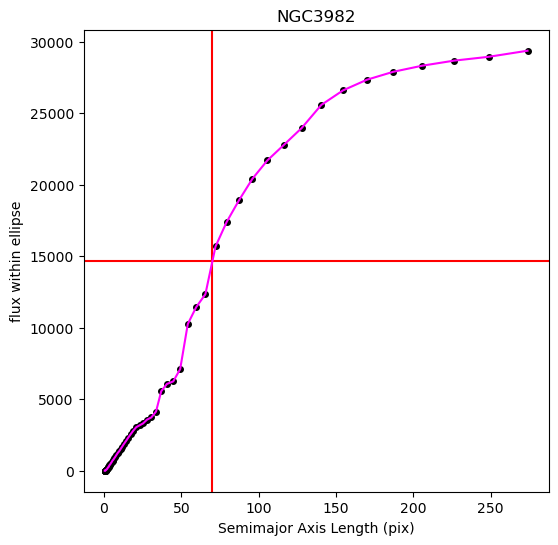

In [38]:
galname = 'NGC3982'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] =70
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2']*3600

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname]*pixscale

plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


### NGC 5198

flux of largest isophote =  25025.8671875


Text(0.5, 1.0, 'NGC5198')

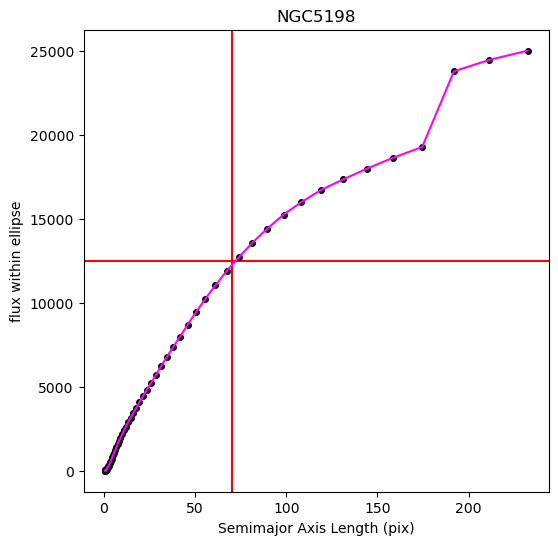

In [39]:
galname = 'NGC5198'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 70
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2']*3600

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname]*pixscale

plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


### NGC 5985

flux of largest isophote =  80900.90625


Text(0.5, 1.0, 'NGC5985')

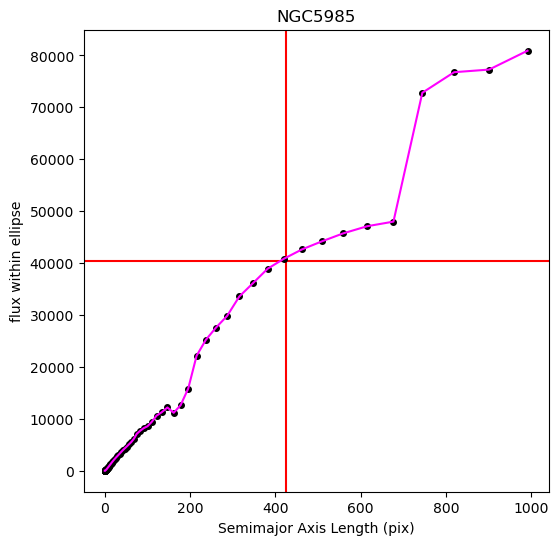

In [40]:
galname = 'NGC5985'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 425
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2']*3600

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname]*pixscale

plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


### PGC 0997820

flux of largest isophote =  901.6207275390625


Text(0.5, 1.0, 'PGC0997820')

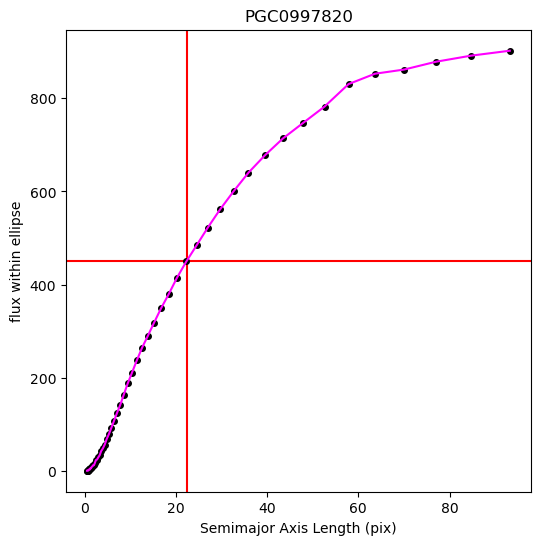

In [41]:
galname = 'PGC0997820'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 22.5
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2']*3600

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname]*pixscale

plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


**Question** For the galaxies above, answer in words written below each bullet:
* For each galaxy how the half-light compares to the visible extent of the galaxy using what you see in the displayed images or in ds9?
NGC3982: It looks like the half-light radius fits pretty well on the image. Inputting the number for our radius onto an ellipse shows that the ellipse fills about half of our visible galaxy making it pretty prefect.
NGC5198: It seems the the half-light radius here barely fits on our image. The light of the elliptical just fits into our elliptical galaxy.
NGC5985:It looks like the half-light radius of this galaxy is bigger than what we see of the galaxy in the image. Just a bit bigger.
PGC0997820: The half-light radius for this galaxy fits nearly half of our galaxy which means it fits very well!

* For each galaxy, which feature of the curve of growth tells you whether you can establish well what the maximum flux is?
Answer: The top of the curve! If the top of our curve flattens out definitively and no longer goes up and/or fluctuates, we know we've reached max flux.

* For each galaxy, use imexam to measure the FWHM of the image using stars in the image.  Then quantify how your half-light radius for each galaxy compares to the FWHM.  
NGC3982: Using the FWHM of five stars, we find the avergae to be 500.
NGC5198:The average was 526
NGC5985: The average is 1251
PGC0997820:The average was 215
It is clear the all our FWHM are much bigger than our half-light radius. This most likely means that our galaxies are actually much bigger than our half-light radii are or there is a lot of influence from the instruments functions on it.

**Question** If the goal of measuring the half-light radius is to obtain light from the galaxy.  What do you think you can do in order to minimize the effect of other sources in the image on this measurment.  

**put answer here**: There are a few things we can consider doing. We can consider background subtraction to reduce background noise, we can use image stacking, or we can use isophotes to analyze areas of similar brightness to reduce mistakes. 

## Problem 5 - construct radial surface brightness profiles (15 Points)

In this problem you will construct radial surface brightness profiles of each galaxy and use them to infer the central surface brightness and that at the half-light radius.

For the purpose of these plots, we will fix the ellipticity and position angle at the values determined at the half-light radius.

You will need to:
* measure mean surface brightness in mag/asec^2 in each annulus
* calculate its uncertainty
* plot the surface brightness profile
* determine the surface brightness at the half-light radius

In [42]:
from photutils.aperture import ApertureStats
from photutils.aperture import EllipticalAnnulus, EllipticalAperture

### NGC 3982

Surface Brightness of 3 arcsec 17.787933848869642
Surface Brightness at Effetive Radius 19.52451306482702
flux_SB(rhalf) / flux_SB(rcent) = 9508863714.684


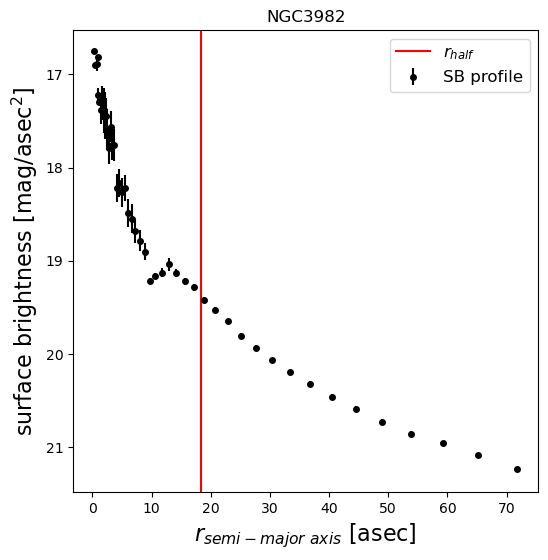

In [51]:
galname = 'NGC3982'

#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = isolist[galname].sma - rhalfpix[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * isolist[galname].eps[rhalfpixind]
        b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
        aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats.std
        #the number of pixels in each annulus
        numpix = aperstats.sum_aper_area
        
        #****************************
        #your code here
        #the area of a pixel
        pixarea = pixscale**2
        #Student: We assume each pixel is a square
        #determine the average surface brightness in mag/asec^2.
        sbcent = np.append(sbcent,-2.5*np.log10(avflux/pixarea)+magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        avflux_err = aperstats.std/np.sqrt(numpix) #Student: The error is the standard deviation of the pixels in an annulus
        #Student: over the square root of the number of pixels in each annulus. This is how we get a standard error of a mean.
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, avflux_err/avflux)
        #Student: Since this is a magnitude uncertainty, we can use differentials to get the flux error over the flux to get our
        #magnitude error (aka surface brightness).

fig,ax = plt.subplots(figsize=(6, 6))

#plot the semi-major axis vs. magnitude
ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
index_3arcsec = np.where(rcent <= 3)[0][-1]
sb_of_3= sbcent[int(index_3arcsec)]
print('Surface Brightness of 3 arcsec:', sb_of_3)

#calculate print out the surface brightness at the effective radius
#***********************
#your code here
sb_effective = sbcent[rhalfpixind]
print('Surface Brightness at Effetive Radius:',sb_effective)

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here
flux_rat = 10**((sb_of_3-sb_effective/2.5))
#Student: This is when we move the flux ratio to one side. We can use our surface brightness magnitudes as mags
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')


### NGC 5198

Surface Brightness of 3 arcsec: 18.287652137217172
Surface Brightness at Effetive Radius: 19.354862366684756
flux_SB(rhalf) / flux_SB(rcent) = 35132349179.518


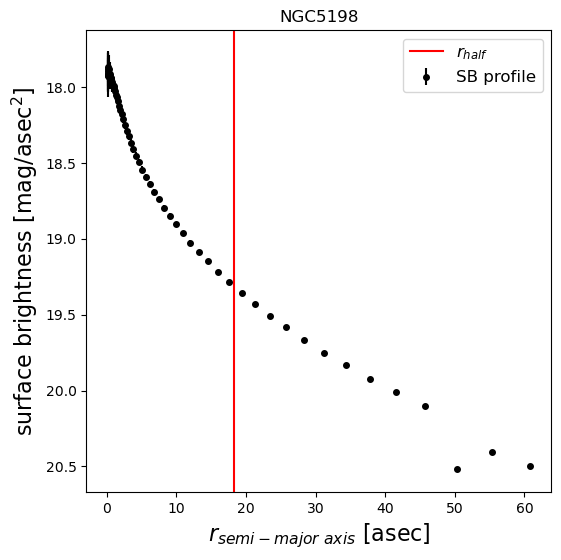

In [55]:
galname = 'NGC5198'

diff = isolist[galname].sma - rhalfpix[galname]

rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

magzp = header[galname]['MAGZERO']

pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    
        a_in = 0.01

        if aindx>0:
        #
            b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
            annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
            aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
            a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
            rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
            avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
            stdflux = aperstats.std
        #the number of pixels in each annulus
            numpix = aperstats.sum_aper_area
        
        #the area of a pixel
            pixarea = pixscale**2
        #Student: We assume each pixel is a square
        #determine the average surface brightness in mag/asec^2.
            sbcent = np.append(sbcent,-2.5*np.log10(avflux/pixarea)+magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
            avflux_err = aperstats.std/np.sqrt(numpix) #Student: The error is the standard deviation of the pixels in an annulus
        #Student: over the square root of the number of pixels in each annulus. This is how we get a standard error of a mean.
            avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
            sbcent_err = np.append(sbcent_err, avflux_err/avflux)
        #Student: Since this is a magnitude uncertainty, we can use differentials to get the flux error over the flux to get our
        #magnitude error (aka surface brightness).

fig,ax = plt.subplots(figsize=(6, 6))

ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

index_3arcsec = np.where(rcent <= 3)[0][-1]
sb_of_3= sbcent[int(index_3arcsec)]
print('Surface Brightness of 3 arcsec:', sb_of_3)

sb_effective = sbcent[rhalfpixind]
print('Surface Brightness at Effetive Radius:',sb_effective)

flux_rat = 10**((sb_of_3-sb_effective/2.5))
#Student: This is when we move the flux ratio to one side. We can use our surface brightness magnitudes as mags
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')



### NGC 5985

Surface Brightness of 3 arcsec: 19.077220914222714
Surface Brightness at Effetive Radius: 21.000612888658267
flux_SB(rhalf) / flux_SB(rcent) = 47530869465.016


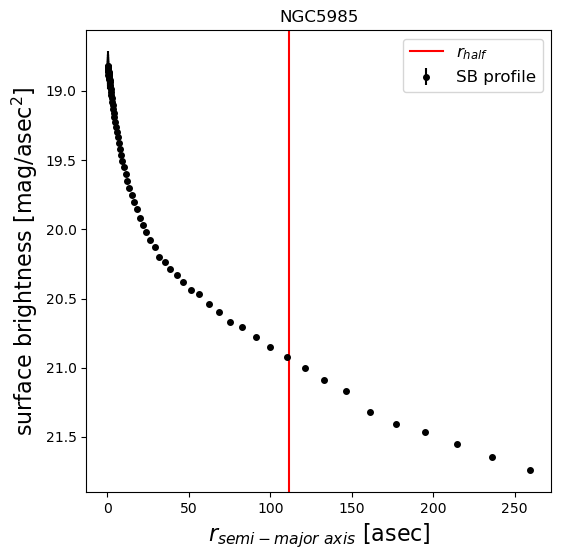

In [59]:
galname = 'NGC5985'

diff = isolist[galname].sma - rhalfpix[galname]

rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

magzp = header[galname]['MAGZERO']

pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    
        a_in = 0.01

        if aindx>0:
        #
            b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
            annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
            aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
            a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
            rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
            avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
            stdflux = aperstats.std
        #the number of pixels in each annulus
            numpix = aperstats.sum_aper_area
        
        #the area of a pixel
            pixarea = pixscale**2
        #Student: We assume each pixel is a square
        #determine the average surface brightness in mag/asec^2.
            sbcent = np.append(sbcent,-2.5*np.log10(avflux/pixarea)+magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
            avflux_err = aperstats.std/np.sqrt(numpix) #Student: The error is the standard deviation of the pixels in an annulus
        #Student: over the square root of the number of pixels in each annulus. This is how we get a standard error of a mean.
            avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
            sbcent_err = np.append(sbcent_err, avflux_err/avflux)
        #Student: Since this is a magnitude uncertainty, we can use differentials to get the flux error over the flux to get our
        #magnitude error (aka surface brightness).

fig,ax = plt.subplots(figsize=(6, 6))

ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

index_3arcsec = np.where(rcent <= 3)[0][-1]
sb_of_3= sbcent[int(index_3arcsec)]
print('Surface Brightness of 3 arcsec:', sb_of_3)

sb_effective = sbcent[rhalfpixind]
print('Surface Brightness at Effetive Radius:',sb_effective)

flux_rat = 10**((sb_of_3-sb_effective/2.5))
#Student: This is when we move the flux ratio to one side. We can use our surface brightness magnitudes as mags
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')

### PGC 0997820

Surface Brightness of 3 arcsec: 20.783708918654444
Surface Brightness at Effetive Radius: 21.177948779617772
flux_SB(rhalf) / flux_SB(rcent) = 2053664078786.495


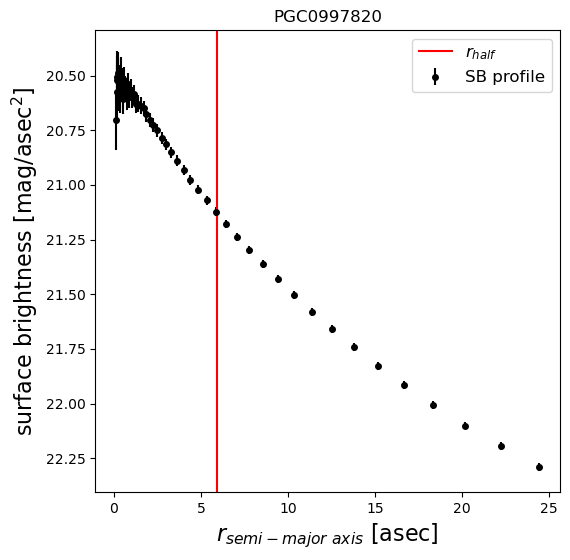

In [58]:
galname = 'PGC0997820'

diff = isolist[galname].sma - rhalfpix[galname]

rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

magzp = header[galname]['MAGZERO']

pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    
        a_in = 0.01

        if aindx>0:
        #
            b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
            annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
            aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
            a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
            rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
            avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
            stdflux = aperstats.std
        #the number of pixels in each annulus
            numpix = aperstats.sum_aper_area
        
        #the area of a pixel
            pixarea = pixscale**2
        #Student: We assume each pixel is a square
        #determine the average surface brightness in mag/asec^2.
            sbcent = np.append(sbcent,-2.5*np.log10(avflux/pixarea)+magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
            avflux_err = aperstats.std/np.sqrt(numpix) #Student: The error is the standard deviation of the pixels in an annulus
        #Student: over the square root of the number of pixels in each annulus. This is how we get a standard error of a mean.
            avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
            sbcent_err = np.append(sbcent_err, avflux_err/avflux)
        #Student: Since this is a magnitude uncertainty, we can use differentials to get the flux error over the flux to get our
        #magnitude error (aka surface brightness).

fig,ax = plt.subplots(figsize=(6, 6))

ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

index_3arcsec = np.where(rcent <= 3)[0][-1]
sb_of_3= sbcent[int(index_3arcsec)]
print('Surface Brightness of 3 arcsec:', sb_of_3)

sb_effective = sbcent[rhalfpixind]
print('Surface Brightness at Effetive Radius:',sb_effective)

flux_rat = 10**((sb_of_3-sb_effective/2.5))
#Student: This is when we move the flux ratio to one side. We can use our surface brightness magnitudes as mags
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')

**Question** Describe the ratio in surface brightness between the center and outskirts including the following points:
* Are there differences between ellipticals and spirals?
* Answer: It looks like the spirals have grater flux ratios than ellipticals which means the spiral galaxies have a greater difference in light between the outskirts and center.
* Does the degree to which your galaxy is well resolved matter?
* Answer: Yes, it does. Well resolved galaxies are easier to look at and interpret due to finer detail as well as better isophote fitting due to those details.
* Does the behavior of the light profile differ inside and outside of the half-light radius?
* Answer: Yes, it does. The half-light radius contains within half the total light of the galaxy. Inside the radius, we'll see light more concentrated while outsideof it is more spaced out. The light profile will probably be steeper inside due to the concentration of light while the outsides profile will plateau more and become shallow.  
* which galaxies have light profiles consistent with being exponential, and in what part of the profiles
* Answer: It is the spiral galaxies that prove to be more exponenrtial. We can see the curves on those profiles move up almost uniformly before sharply getting steeper. This is a clear indicator of exponential distribution. It is as we go towards the center of the galaxy that we see it becoming steeper due, again, to high light concentration. Though, it does look like one of the ellipticals shows some exponential as well so it isn't only spiral galaxies that experince it thoguh it seem spirals do experince more.

**answer goes here**